In [166]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from sklearn.ensemble import IsolationForest
from scipy import stats
from statsmodels.formula.api import ols

This codebook is the codebook used to review and analyze the cleaned data

# Load Dataset

In [114]:
df = pickle.load(open('final_df.pkl', 'rb'))

# Additional Feature Engineering

While the flags provided by the USDA do provide good detail on the different census tracts, the complexity of these flags and the amount of overlap make them difficult to assess and to use in an ANOVA test. Therefore, I will create two new features from these flags.

1) Tract Status: A 3 level category. 
    0: Tract is not low food access under any measure
    1: Tract is low access under any of the measures, but is not low income
    2: Tract is low access under any of the measures, and is low income

2) Low Access - Vehicle: a 3 level category.
    0: Tract is not low food access under any measure
    1: Tract is low access under the vehicle definition but not under any other definition
    2: Tract is low access under at least one other measure other than vehicle

In [115]:
# Function to classify tract status
def tract_status_update(row):
    LIStatus = (row['LILATracts_1And10'] + row['LILATracts_halfAnd10'] + row['LILATracts_1And20'] + row['LILATracts_Vehicle'])
    LAStatus = row['LA1and10'] + row['LAhalfand10'] + row['LA1and20'] + row['LATractsVehicle_20']
    # Checks if tract is marked as LILA under any measure
    if LIStatus > 0:
        return 2
    # Checks if tract is marked LA under any measure
    if LAStatus > 0:
        return 1
    else:
        return 0

df['tract_status'] = df.apply(tract_status_update, axis=1)

In [116]:
# Function to update LAVehicle
def va_update(row):
    la = row['LILATracts_1And10'] + row['LILATracts_halfAnd10'] + row['LILATracts_1And20'] + row['LA1and10'] + row['LAhalfand10'] + row['LA1and20']
    vehicle = row['LILATracts_Vehicle'] + row['LATractsVehicle_20']
    
    # Checks if the tract is low access under the vehicle definition but not under the other definitions
    if vehicle > 0 and la == 0:
        return 1
    # Checks if tract is low access under any other measure
    if la > 0:
        return 2
    else:
        return 0
    
df['LAVehicle'] = df.apply(va_update, axis = 1)

In [117]:
# Check structure of data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144951 entries, 0 to 145323
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   ncessch               144951 non-null  category
 1   CensusTract           144951 non-null  category
 2   cohort_num            144951 non-null  int64   
 3   cohort_cat            144951 non-null  category
 4   school_level          144951 non-null  category
 5   charter               144951 non-null  category
 6   title_i_status        144951 non-null  category
 7   lunch_program         144951 non-null  category
 8   magnet                144951 non-null  category
 9   shared_time           144951 non-null  category
 10  virtual               144951 non-null  category
 11  LILATracts_1And10     144951 non-null  category
 12  LILATracts_halfAnd10  144951 non-null  category
 13  LILATracts_1And20     144951 non-null  category
 14  LILATracts_Vehicle    144951 non-nul

# Review Gradaution Rates

A brief look at the statistics shows a large range of gradaution rates from 1 to 99 and the data is centered around 68%. Looking at the historgram shows a significant spike around 50 with the majority of the data being 50% or higher and a small tail to the left. 

In [118]:
df['grad_rate'].describe()

count    144951.000000
mean         68.375941
std          17.474477
min           1.000000
25%          50.000000
50%          67.000000
75%          84.000000
max          99.000000
Name: grad_rate, dtype: float64

<Axes: xlabel='grad_rate', ylabel='Count'>

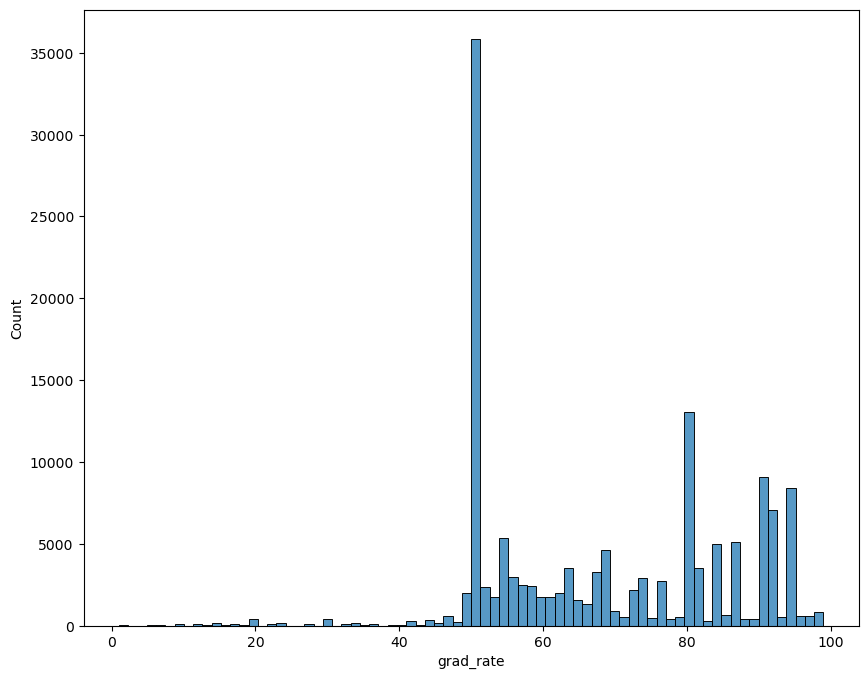

In [119]:
fig, ax = plt.subplots(figsize=(10,8))

sns.histplot(data=df, x='grad_rate', ax=ax)

# Sample Reduction

While I have already done some qualitative filtering of schools that I didn't feel were representative of the population I wanted to study. I'd like to do some additional review to determine if I should narrow the schools down that I include to try and control for other factors that may contribute to graduation rate differences

## Addressing Unavailable Data

As a first step, I'll look at the magnet, shared time, and virtual schools to see if I can determine whether the schools that had that flag missing should be included in the population sample or not.

For the schools lacking this tag, I could not find a reliable, non-labor intensive way to validate whether they should be included in the analysis or not. Without further domain knowledge or extensisve research, my best option is to approximate the probability that these schools should be considered using a few different methods.

First, I am working under the assumption that there is a higher probability that any school missing this tag is *not* a school of that type, since schools of this type are less common. Therefore, without evidence to indicate that they should not be included, I will include them.

To look for this evidence I will look at two things. First I will use boxplots and the Kruskal-Willis test to assess whether it is likely that these schools come from the same population by assessing the probability that the populations share a median. 

Next, I will use countplots and a chi squared test to assess the likelihood that any difference in the medians is due to an unequal distribution across tract stuatuses rather than being from a different population.

The magnet school category does have some rows that are flagged with -2 instead of -1. This indicates that the flag is not applicable, rather than not reported. Since it is not applicable, I can assume that means that it is *not* a magnet school. So before compelting the analysis I will update those schools accordingly.

Also, the virtual feature had cateogires of 0 for not virtual and 3 for 'supplemental virtual' which I included as essentially not-virtual. I will also update these to make the anlaysis easier.

In [120]:
# Update values
df['magnet'] = df['magnet'].apply(lambda x: 0 if x == -2 else x)
df['virtual'] = df['virtual'].apply(lambda x: 0 if x == 3 else x)

# Check that new values are just 0 and -1
print(df['magnet'].unique())
print(df['virtual'].unique())

[ 0. -1.]
[ 0. -1.]


In [121]:
# Calculate the Kruskal-Wallis scores for the three features

magnet_kw = stats.kruskal(df[(df['magnet'] == -1)]['grad_rate'], df[(df['magnet'] == 0)]['grad_rate'])

shared_time_kw = stats.kruskal(df[df['shared_time'] == -1]['grad_rate'], df[df['shared_time'] == 0]['grad_rate'])

virtual_kw = stats.kruskal(df[df['virtual'] == -1]['grad_rate'], df[(df['virtual'] == 0)]['grad_rate'])

# Create the tables for the chi squared test
ctab_magnet = pd.crosstab(df['tract_status'], df['magnet'])

ctab_shared_time = pd.crosstab(df['tract_status'], df['shared_time'])

ctab_virtual = pd.crosstab(df['tract_status'], df['virtual'])

# Complete chi squared test for each feature
magnet_chi = stats.chi2_contingency(ctab_magnet).pvalue

shared_time_chi = stats.chi2_contingency(ctab_shared_time).pvalue

virtual_chi = stats.chi2_contingency(ctab_virtual).pvalue

In all three cases, there is a statistically significant difference in the medians of the groups, but there is also evidence that the difference could be a result of their tract status since the chi squared test indicates a low probability that the schools are distributed among the different tract statuses equally. Teh box plots and the count plots also visually appear to align with this finding. 

Since I can't confidently disregard these schools, I will keep them in my dataset under the assumption that they are part of the population I want to study. 

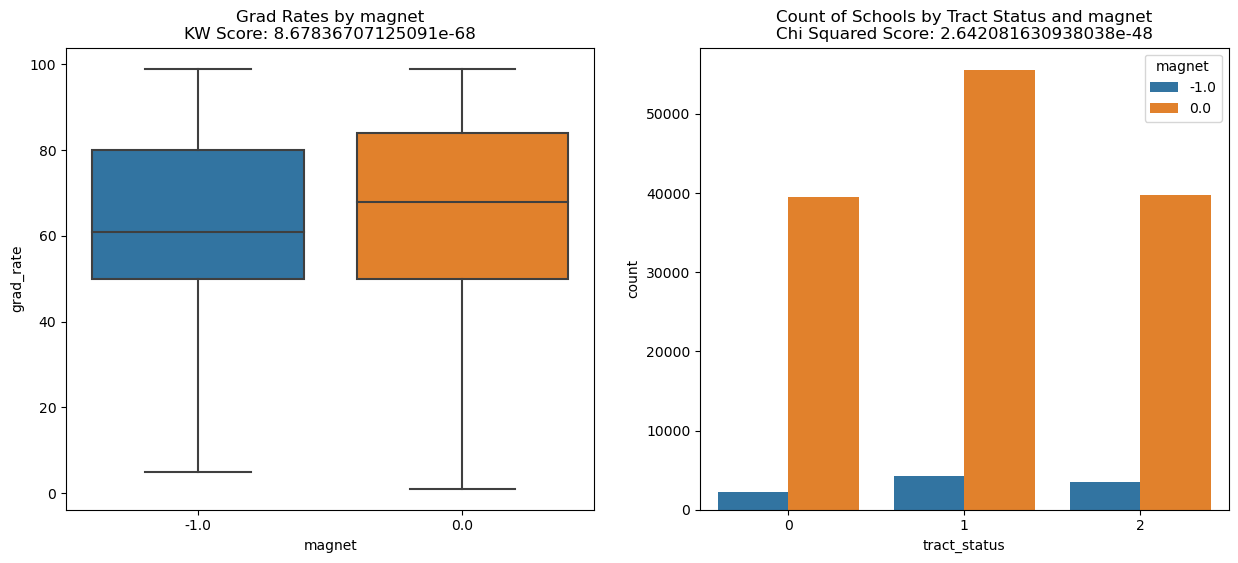

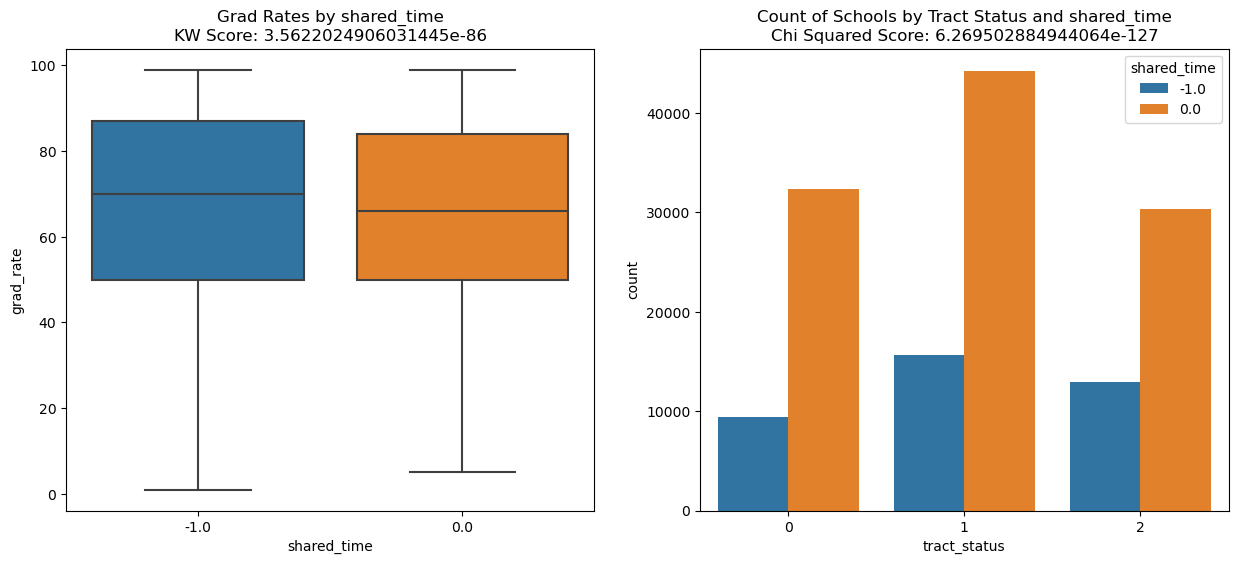

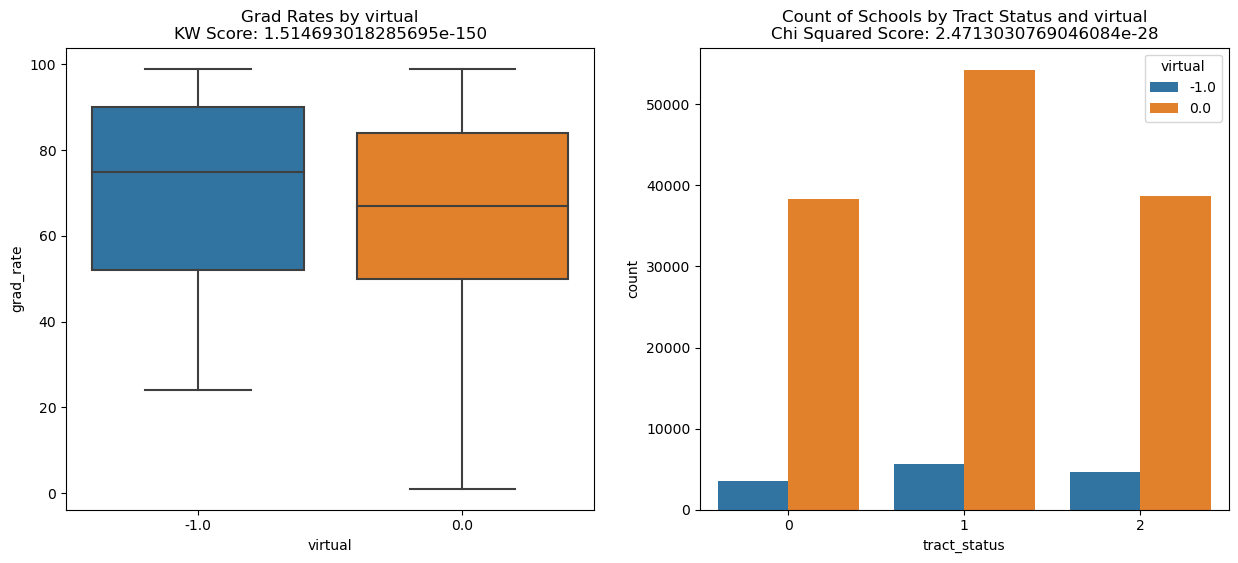

In [122]:

cols = ['magnet', 'shared_time', 'virtual']
score = [[magnet_kw, magnet_chi], [shared_time_kw, shared_time_chi], [virtual_kw, virtual_chi]]

# Loop for plotting the results
for i, col in enumerate(cols):
    # Get the kw and chi score for that feature from the list. 
    kw = score[i][0]
    chi = score[i][1]

    fig, ax = plt.subplots(ncols=2, figsize=(15,6))
    # Plot a box plot to visually assess data and kw score to statistically assess it
    sns.boxplot(data=df, y='grad_rate', x = col, ax=ax[0])
    ax[0].set_title(f'Grad Rates by {col}\nKW Score: {kw.pvalue}', loc='center')
    # Plot countplot to visually assess distribution and chi square score to statistically assess it
    sns.countplot(data=df, x='tract_status', hue=col, ax=ax[1])
    plt.title(f'Count of Schools by Tract Status and {col}\nChi Squared Score: {chi}', loc='center')
    
    plt.show()

In [123]:
# Dropping the columns
df.drop(columns=['magnet', 'shared_time', 'virtual'], inplace=True)

## Cohort Category

As would be expected from other research on education, graduation rates are highly varied for different cohorts with higher graduation rates for white students and lower graduation rates for other races. While it would be a very interesting study to look at whether certain cohorts experience a greater impact from food access than others, it would require a much more in depth review than the scope of this project. Additionally, knowing that the majority of my imputed values were for small sub-cohorts, removing them will somewhat mitigate any inaccuracy in the assumptions I made for that process. Therefore, I will drop the sub-cohorts from this dataset and focus only on the overall graduation rates for each school. 

A note that this means I won't be able to rule out that any differences I find aren't a result of geographic segregation by these sub-cohorts (i.e. that the probability of being high food access is highly correlated with racial makeup of a particular geography), but that is a larger study than I am attempting here. 

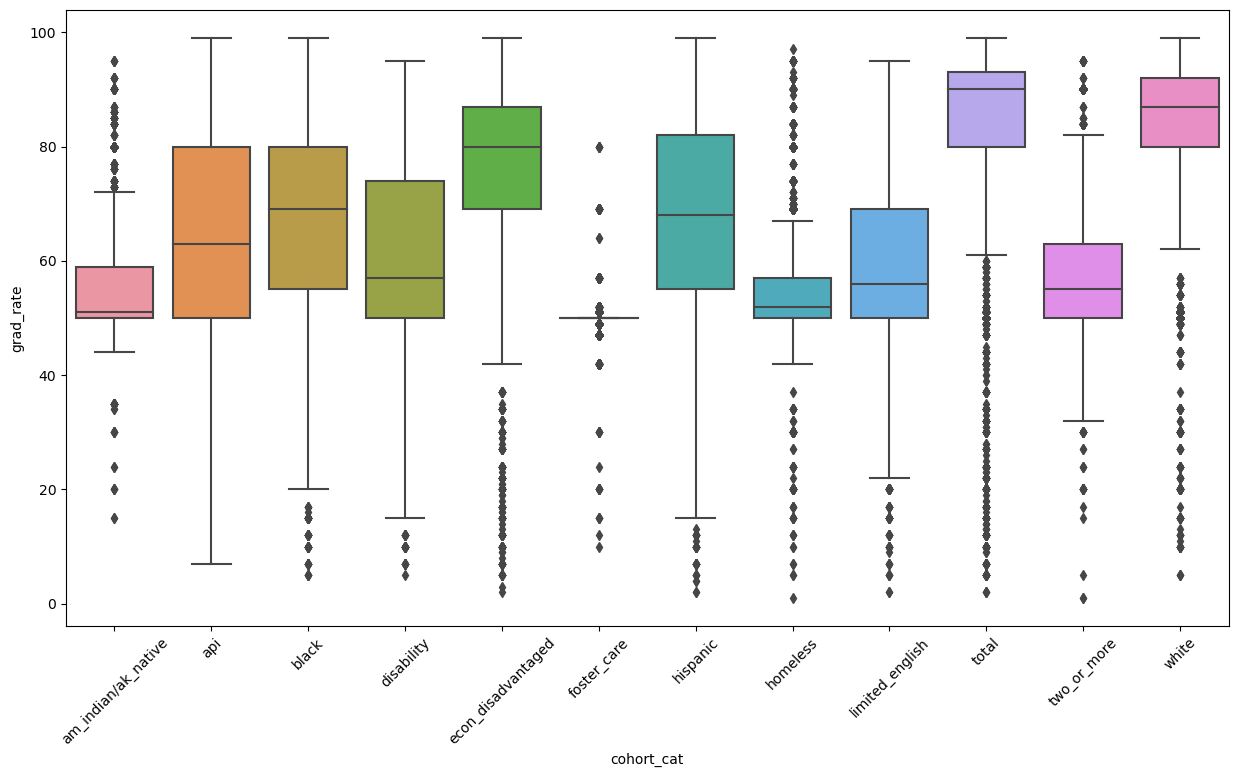

In [124]:
fig, ax = plt.subplots(figsize = (15, 8))

sns.boxplot(data = df, x= 'cohort_cat', y='grad_rate', ax=ax)
plt.xticks(rotation=45)
plt.show()

In [125]:
# Remove sub-cohorts from data

print(f'Prior to filtering there were {len(df)} observations')

df = df[df['cohort_cat'] == 'total']

print(df['cohort_cat'].unique())

# Drop column
df.drop(columns=['cohort_cat'], inplace=True)

print(f'After filtering there were {len(df)} observations')

Prior to filtering there were 144951 observations
['total']
Categories (12, object): ['am_indian/ak_native', 'api', 'black', 'disability', ..., 'limited_english', 'total', 'two_or_more', 'white']
After filtering there were 17037 observations


## School Level

School level indicates what grades are taught at that school (e.g. 6-8, 9-12, 6-12, etc.)

Once again, there is a fairly signficant variation in the different school levels. If graduation rates were less varied across the school level, I would consider using all of them in the analysis, but since there is significant variation I will pick a specific level to ensure that any differences identified in the test are focused on our feature of study. Since we know schools are going to be relatively equally distributed by level across geographies, there isn't a concern that school level and tract would be highly correlated. 

Primarily from my own interest, I will use category 3 which represents standard high school (grades 9-12). 

Note: There is one school that did not have the school level avaialble, however looking it up in nces.ed.gov it covers grades 7-12 so we will exclude it from our data.

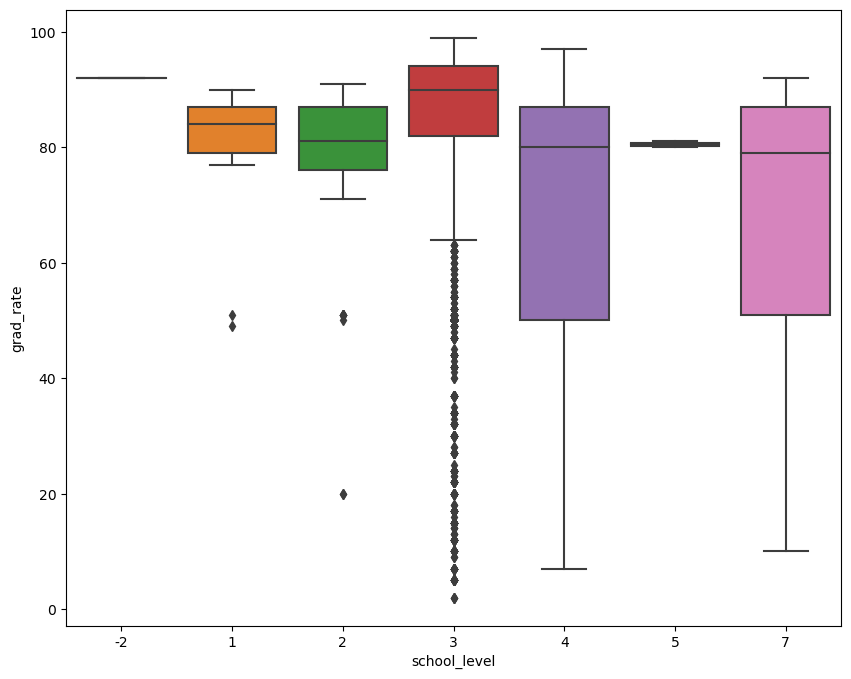

In [126]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='school_level', y='grad_rate')

plt.show()

In [127]:
# Check school missing this information
df[df['school_level'] == -2]

,ncessch,CensusTract,cohort_num,school_level,charter,title_i_status,lunch_program,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,LA1and10,LAhalfand10,LA1and20,LATractsVehicle_20,grad_rate,tract_status,LAVehicle
23336,60254208363,6087101200,88,-2,1,6.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,92,2,2


In [128]:
# Remove all schools except level 3
print(f'Prior to filtering there were {len(df)} observations')
df = df[df['school_level'] == 3]

print(df['school_level'].unique())

# Drop column
df.drop(columns=['school_level'], inplace=True)

print(f'After filtering there were {len(df)} observations')

Prior to filtering there were 17037 observations
[3]
Categories (7, int64): [-2, 1, 2, 3, 4, 5, 7]
After filtering there were 15365 observations


## Check Diustribution of Target Again

Now that I've limited the population of interest to just overall graduation rates for high school, I will look at the distribution again to see how it's changed.

It looks like these adjustments have significantly change dthe distribution. The spike at 50% had decreased significantly, this makes sense since from the cohort boxplot we could see that much of that seemed to be a result of certain cohorts having lower rates and cluserting around that rate. 

We now have a highly skewed plot with the majority of graduation rates at or above 80 and a long tail for gradution rates down to 1.

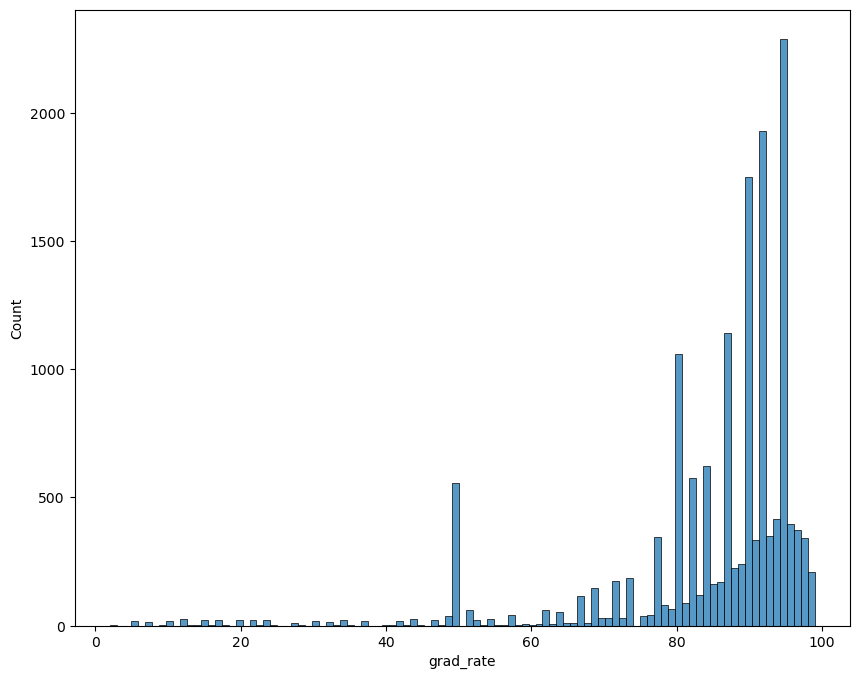

In [129]:
fig, ax = plt.subplots(figsize=(10,8))

sns.histplot(data=df, x='grad_rate', ax=ax)

plt.show()

# Analyzing Other Features

For the remaining features, I would like to explore whether any of them may contribute to graduation rates. And if I should include them as interactions in my ANOVA test to explore whether they are influencing the gradaution rate or interacting with the food access features. 

## Title I Status

The dataset breaks this down into 6 different levels based on which program a school is eligible for and whether it's offered at that school. I am going to simplify this by looking at just whether a school is not eligible (0), is eligible and offers the program (1), or is eligible but does not offer a program (2).

Looking at this breakdown, there appears to be a significant difference in the graduation rates for schools that are missing this tag. This indicates there is some correlation between missing this tag and graduation rates. These schools are a very small portion of the overall data though, so leaving them in or taking them out shouldn't impact the analysis significantly. A rough look at percentages shows that the schools seem to be roughly evenly distributed across the tract categories so I will choose to drop them from the study for simplicity. 

It does appear that there may be a correlation between graduation rates and title I status.

In [130]:
def title_i_update (x):
    if x in [1, 4]:
        return 2
    if x in [2, 3, 5]:
        return 1
    if x == 6:
        return 0
    else: 
        return -1

df['title_i'] = df['title_i_status'].apply(title_i_update)

df.drop(columns=['title_i_status'], inplace=True)

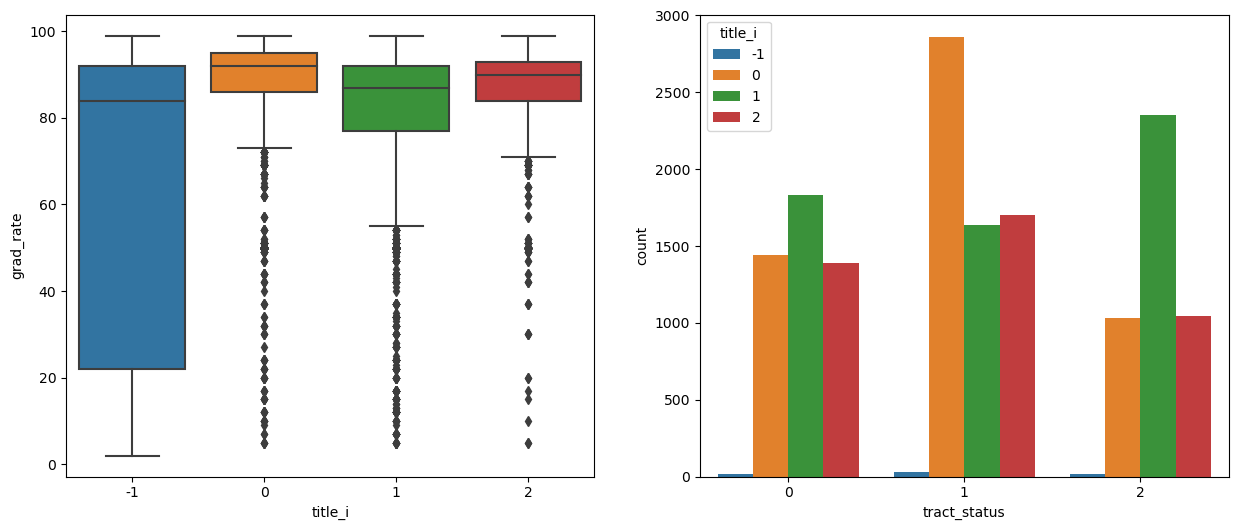

In [131]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

sns.boxplot(data=df, x='title_i', y='grad_rate', ax=ax[0])
sns.countplot(data=df, x = 'tract_status', hue='title_i', ax=ax[1])
plt.show()

In [132]:
df[df['title_i'] == -1]

for i in range(3):
    percent_title_i = (len(df[(df['title_i'] == -1) & (df['tract_status'] == i)])/len(df[df['title_i']==-1]))*100
    percent_tract = (len(df[df['tract_status'] == i])/len(df)*100)
    print(f'Tract Status {i}\n')
    print(f'{percent_title_i}% of missing tags are in this tract')
    print(f'{percent_tract} of the observations are in this tract\n')

Tract Status 0

26.47058823529412% of missing tags are in this tract
30.49788480312398 of the observations are in this tract

Tract Status 1

45.588235294117645% of missing tags are in this tract
40.540188740644325 of the observations are in this tract

Tract Status 2

27.941176470588236% of missing tags are in this tract
28.961926456231694 of the observations are in this tract



In [133]:
# Drop schools missing this data
df = df[df['title_i'] != -1]

# Check new values
print(df['title_i'].unique())

[1 0 2]


## Lunch Program

Similar to title I, this dataset provides 5 categories for the school lunch program that specify whether a school is participating and if so, what provision it is participating under. I am going to simplify this data by just looking at whether a school is participating (1) or not (0).

Again, we have a number of schools that are missing the tag for their participatiuon in the lunch program. Given that there seems to potentially be a relationship between school lunch program and graduation rates looking at the boxplot, I'd like to include this in my analaysis. Since I don't know which group these belong to, I will again use the Kurskal-Willis test to determine which group it is more likely that these schools belong to. 

Comparing the plots, the chi squared and the KW score I don't have evidence that they belong in either group but there is evidence that they are unequally distributed acorss tract status. However, this only represents 2.5% of the total schools so it shouldn't imapct the results too much. A visual assessment indicates that it's more similar to schools that are not in teh lunch program, so I will recode those accordingly. 

A look at the new plot with these values adjusted shows some difference between the groups, but it's ahrd to tell if it will be significant. 

In [134]:
def lunch_update (x):
    if x == 0:
        return 0
    if x in [1, 2, 3, 4, 5]:
        return 1
    else:
        return -1

df['nslp'] = df['lunch_program'].apply(lunch_update)

df.drop(columns=['lunch_program'], inplace=True)

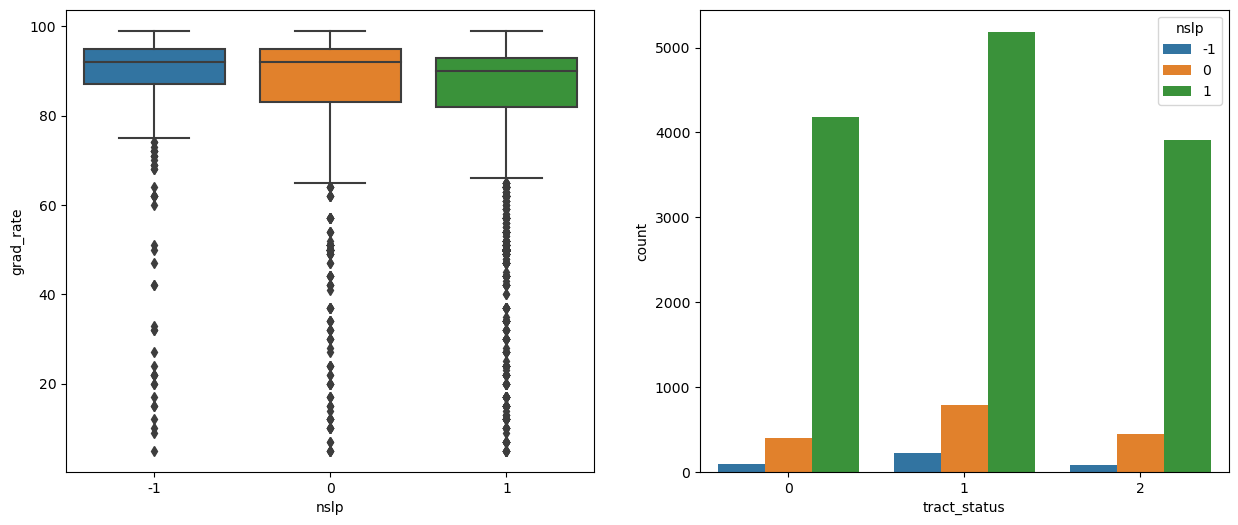

In [135]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6))

sns.boxplot(data=df, x='nslp', y='grad_rate', ax=ax[0])
sns.countplot(data=df, x='tract_status', hue='nslp', ax=ax[1])
plt.show()

In [141]:
not_nslp = stats.kruskal(df[df['nslp'] == -1]['grad_rate'], df[df['nslp'] == 0]['grad_rate']).pvalue

in_nslp = stats.kruskal(df[df['nslp'] == -1]['grad_rate'], df[df['nslp'] == 1]['grad_rate']).pvalue

nslp_tab = pd.crosstab(df['tract_status'], df['nslp'])

nslp_chi = stats.chi2_contingency(nslp_tab)

print('KW p-values:')
print(f'Programs not in NSLP: {not_nslp}\nPrograms in NSLP: {in_nslp}')

print(f'\nChi Squared Value:\n{nslp_chi.pvalue}')

print('\n', (len(df[df['nslp'] == -1])/len(df))*100)

KW p-values:
Programs not in NSLP: 0.02816951785919621
Programs in NSLP: 1.2934676491539648e-16

Chi Squared Value:
7.688094369668355e-21

 2.556056743152252


In [142]:
df['nslp'] = df['nslp'].apply(lambda x: 0 if x == -1 else x)

df['nslp'].unique()


array([1, 0], dtype=int64)

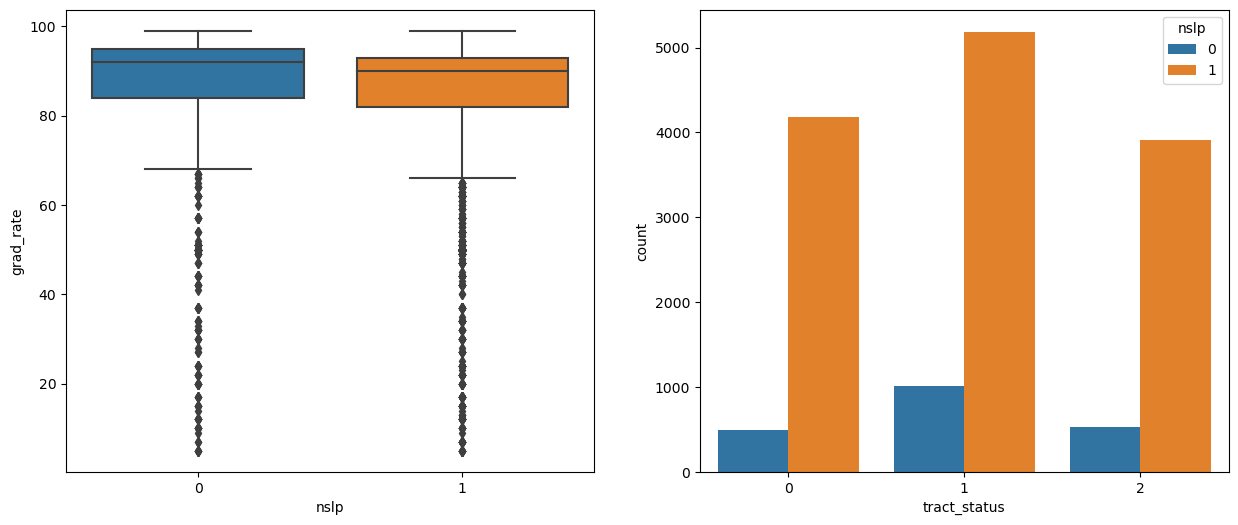

In [143]:
# Replot with -1 values udpated

fig, ax = plt.subplots(ncols=2, figsize=(15,6))

sns.boxplot(data=df, x='nslp', y='grad_rate', ax=ax[0])
sns.countplot(data=df, x='tract_status', hue='nslp', ax=ax[1])
plt.show()

## Charter Schools

As with magnet schools, a number of the schools have reported not applicable for charter. This indicates that the geography does not have charter schools, therefore we know they are not charter schools and can update accordingly.

In [144]:
# Update values
df['charter'] = df['charter'].apply(lambda x: 0 if x== -2 else x)

#Check new values
df['charter'].unique()

array([0, 1], dtype=int64)

There appears to be a fairly significant difference in graduation rates for charter and non charter schools, it's ahrd to tell from the countplot however if charter schools are more common in certain tracts or not. 

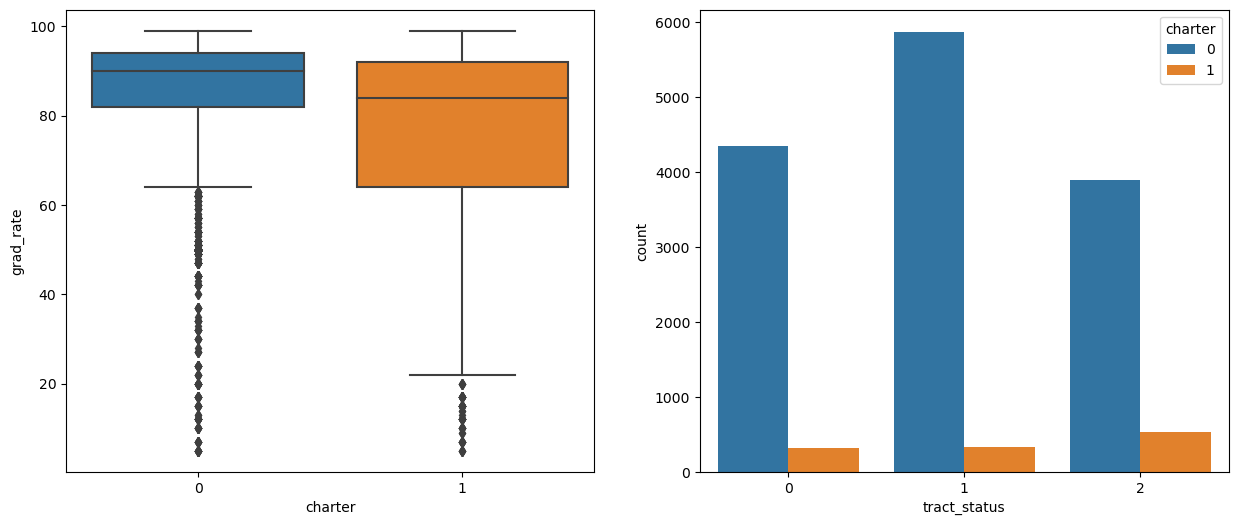

In [145]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6))

sns.boxplot(data=df, x='charter', y='grad_rate', ax=ax[0])
sns.countplot(data=df, x = 'tract_status', hue='charter', ax=ax[1])
plt.show()

# Target Data Exploration

Now that I have filtered and adjusted the data to create reasonably similar groups and identified the features I'll be assessing, I can look at the relationship between food access and graduation rates using the provided feaures and the ones I created

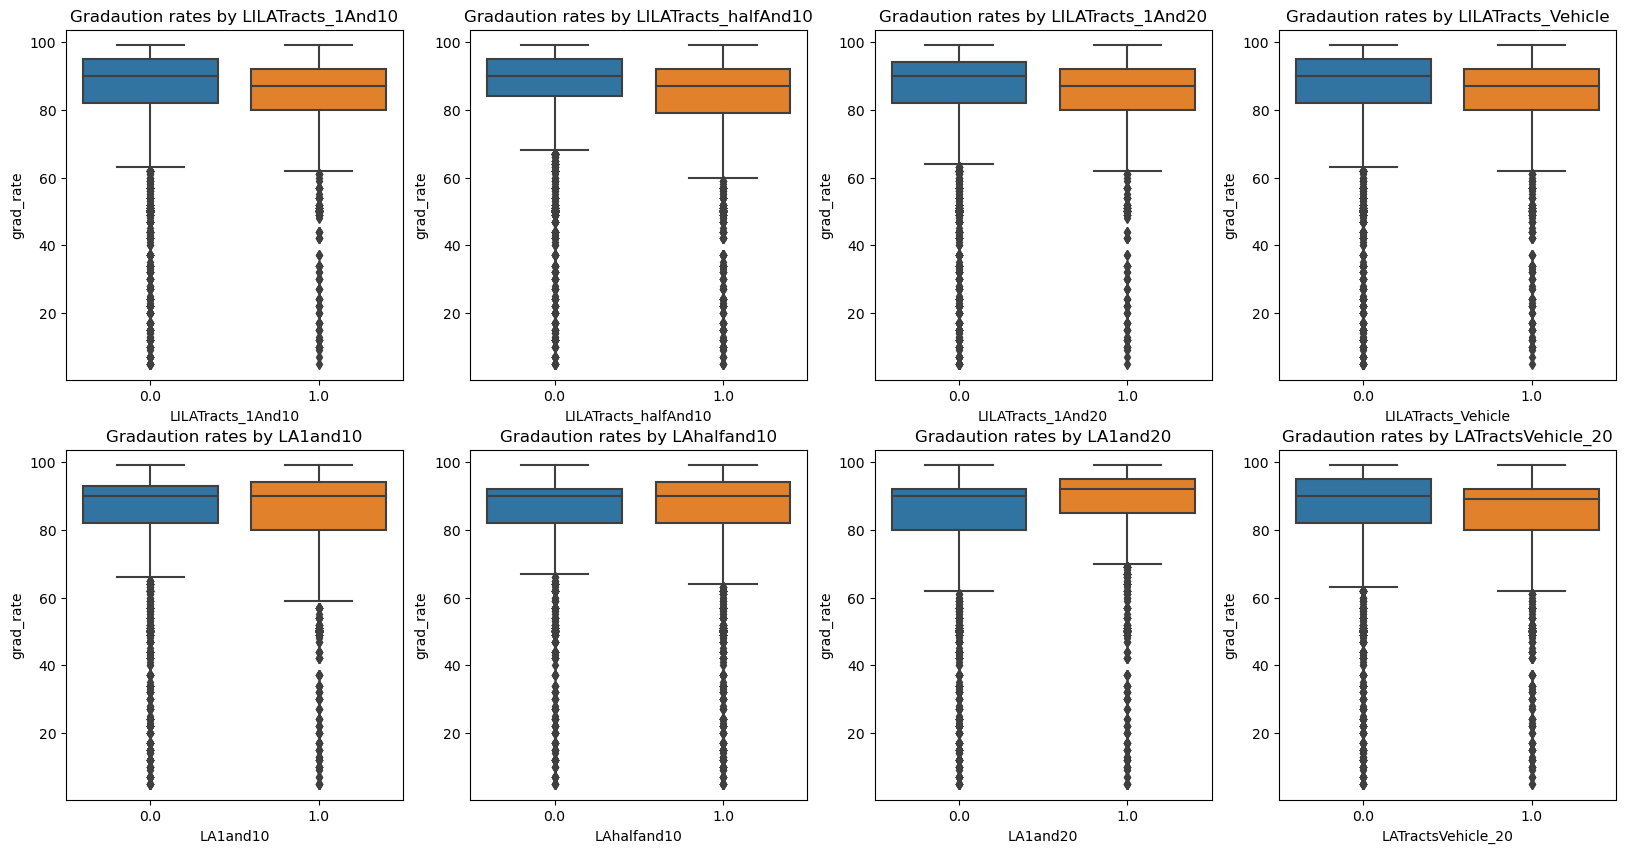

In [146]:
# Plot graduation rates by each of the USDA provided flags

LAFlags = ['LILATracts_1And10', 'LILATracts_halfAnd10', 'LILATracts_1And20', 'LILATracts_Vehicle', 'LA1and10', 'LAhalfand10', 'LA1and20', 'LATractsVehicle_20']

fig, ax = plt.subplots(ncols=4, nrows=2, figsize = (20, 10))
col = 0
row = 0

for flag in LAFlags:
    sns.boxplot(data=df, x = flag, y= 'grad_rate', ax=ax[row][col])
    ax[row][col].set_title(f'Gradaution rates by {flag}')

    if col == 3:
        col = 0
        row += 1
    else:
        col+=1

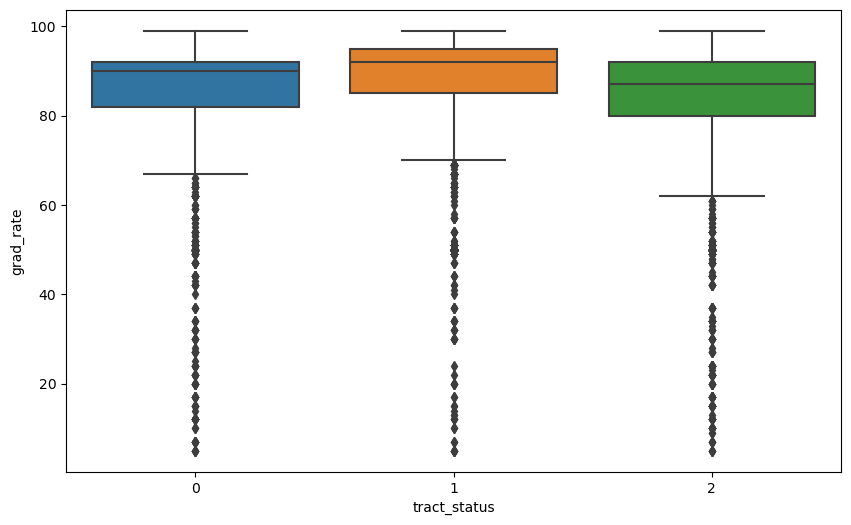

In [147]:
# Plot gradaution rates by the tract status feature
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=df, x='tract_status', y='grad_rate', ax = ax)

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

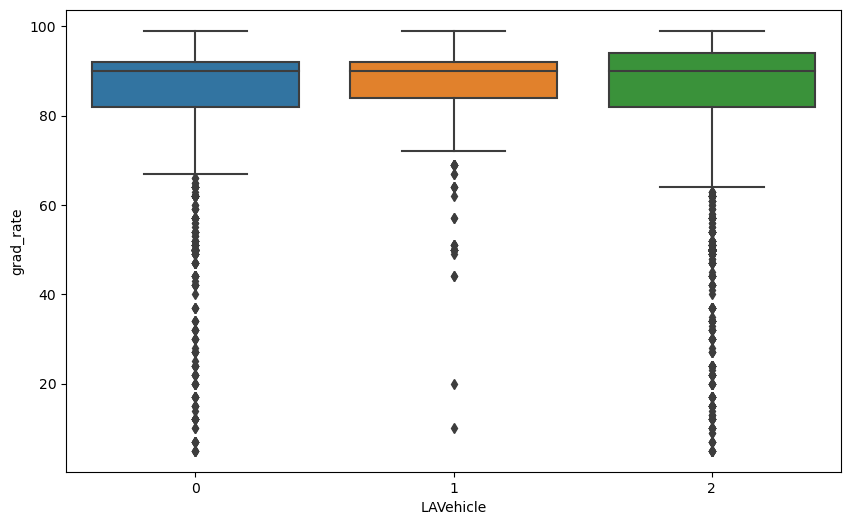

In [148]:
# Plot graduation rates by vehicle access feature

fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=df, x='LAVehicle', y='grad_rate', ax = ax)

plt.show

# Outlier Detection

To explore outliers, I chose to use an Isolation Forest method to isolate any data points that, when looking at the entire set of features, appear to be outliers. Without having a good way to estimate contamination, I left the contamination parameter as teh default and then performed a visual assessment of the scores.

Looking at the anomaly scores, there are a few instances that have significantly negative scores. However, there's not really any place where I would consider that the instance(s) are too dissimilar from any other isntance to indicate that it is a true outlier. Knowing that the data is highly skewed, it would make sense that there would be datapoints that are fairly dissimilar from the majority, but still not an outlier. 

Without any additional domain knowledge to inform this decision, I will choose to leave all the data points in.

In [150]:
features = df[['charter', 'tract_status', 'LAVehicle', 'title_i', 'nslp']]

clf = IsolationForest(random_state=7284, max_features=1.0)
                      

clf.fit(features)


iso_forest_predictions = pd.DataFrame(np.c_[clf.predict(features), 
                                            clf.decision_function(features)], 
                                      columns= ['anomaly_flag', 'anomaly_score'])

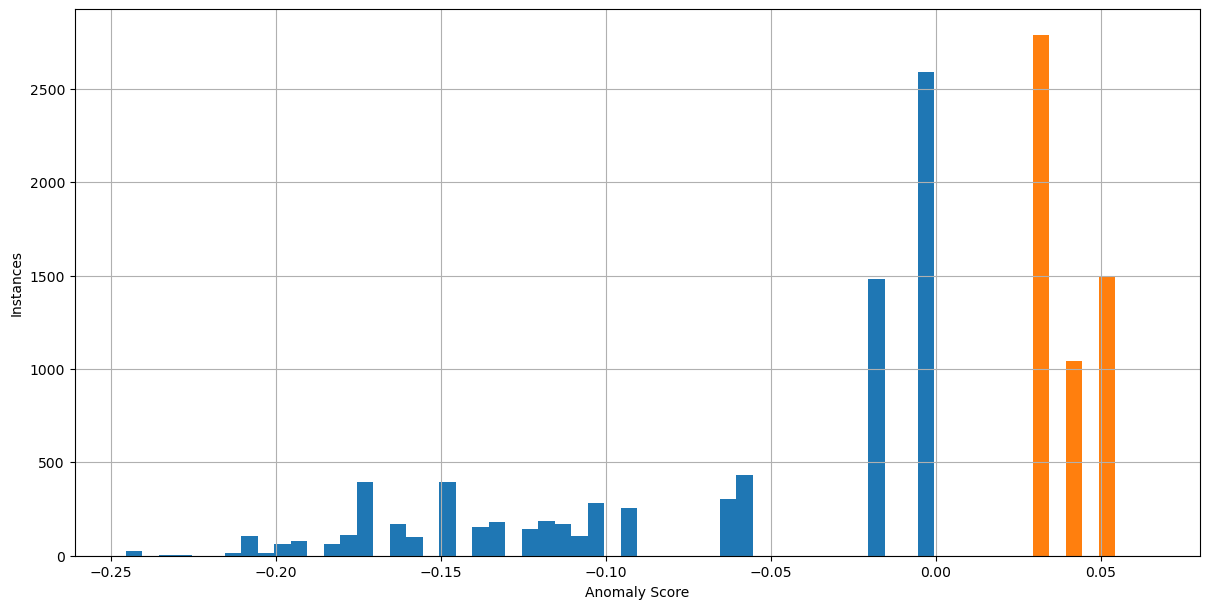

In [151]:
fig, ax = plt.subplots()
iso_forest_predictions.groupby(['anomaly_flag'])['anomaly_score'].hist(
    bins= np.arange(np.min(clf.decision_function(features)), 
                    np.max(clf.decision_function(features)), 0.005),  
    figsize= (12, 6), ax= ax)
fig.tight_layout()
plt.xlabel('Anomaly Score')
plt.ylabel('Instances')
plt.show()

# Transformation of Data

As seen before, we know that our data is highly skewed and we can see from the boxplots that the variance is varied for many of the categories. Since these are both key assumptions for ANOVA I needed to transform my data into a more normal distribution. To do this, I chose to use the boxcox transformation which can help normalize both the distribution and the varaince. As a plus, it will also help mitigate the influence of outliers if my previous assumption was incorrect. 

In [152]:
data_fit, lambda_fit = stats.boxcox(df['grad_rate'])

df['grad_rate_box'] = data_fit

Looking at the new histogram, as well as relooking at a couple boxplots of the features, we can see that the varaince and the distribution are now much better and we can now use teh data to perform the ANOVA test

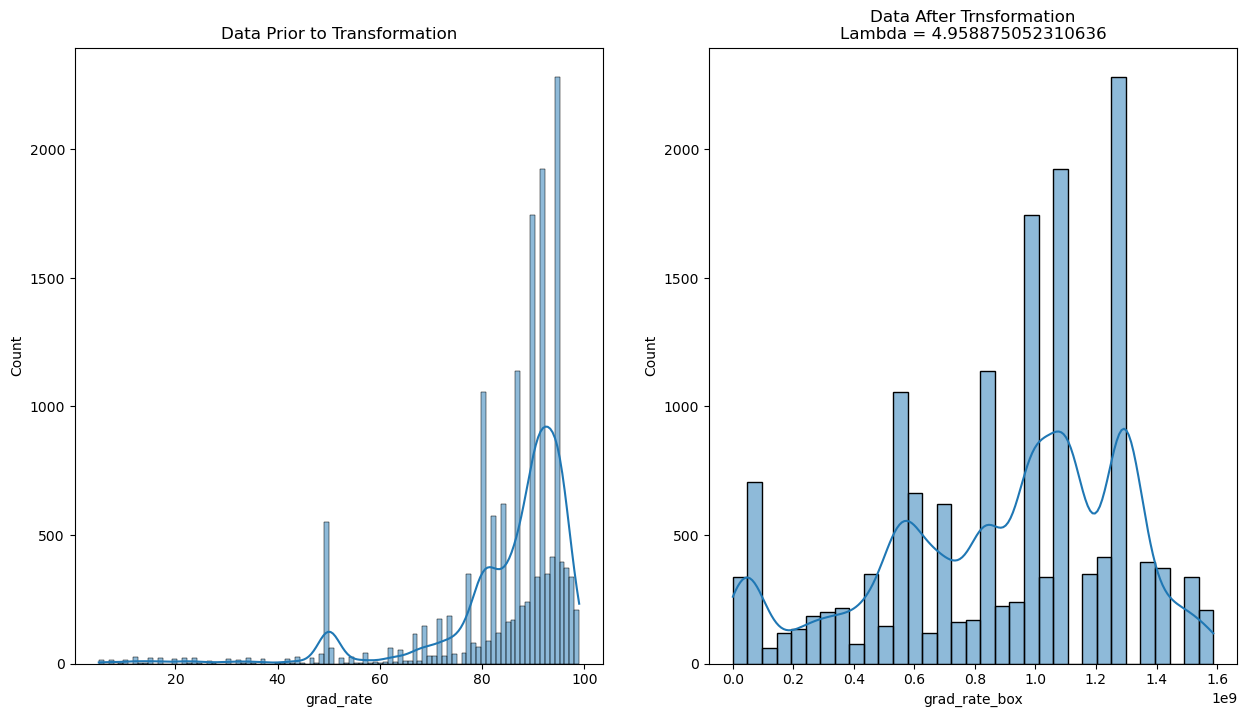

In [153]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))
 

sns.histplot(df['grad_rate'], kde = True, ax=ax[0])
sns.histplot(df['grad_rate_box'], kde=True, ax=ax[1])
 
ax[0].set_title('Data Prior to Transformation')
ax[1].set_title(f'Data After Transformation\nLambda = {lambda_fit}')


plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

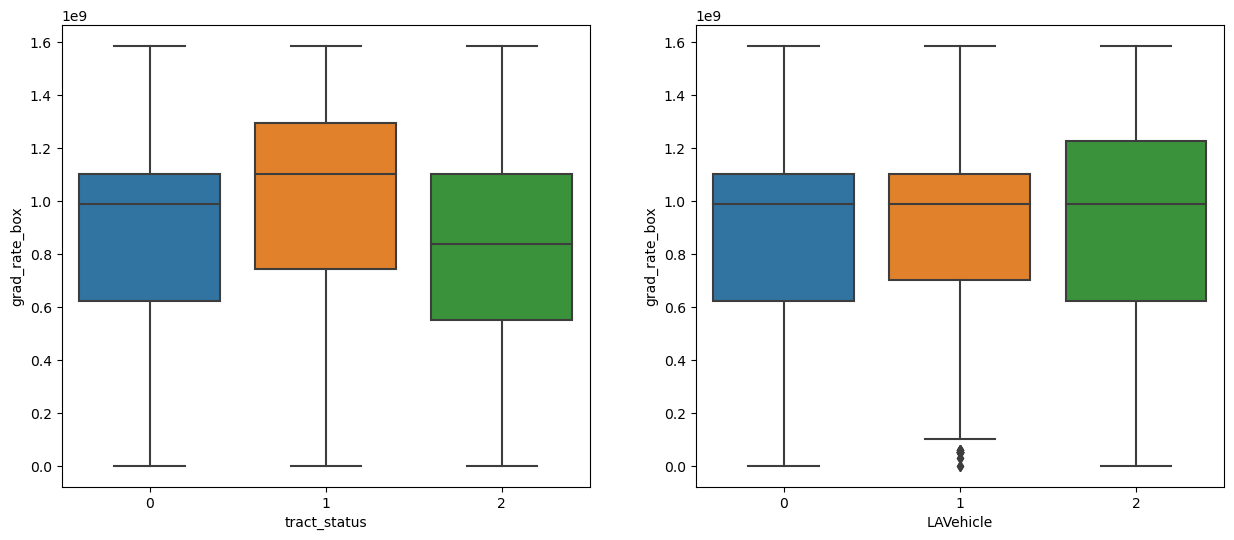

In [157]:
# Plot gradaution rates by the tract status feature
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))

sns.boxplot(data=df, x='tract_status', y='grad_rate_box', ax = ax1)
sns.boxplot(data=df, x='LAVehicle', y='grad_rate_box', ax = ax2)

plt.show

# ANOVA Test

In [183]:
feat_names = list(features.columns)
fmla = '+'.join(feat_names)

model = ols('grad_rate ~ C(tract_status)  + C(charter) + C(tract_status):C(charter)', data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              grad_rate   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     213.6
Date:                Thu, 16 Nov 2023   Prob (F-statistic):          6.35e-221
Time:                        12:38:51   Log-Likelihood:                -61687.
No. Observations:               15297   AIC:                         1.234e+05
Df Residuals:                   15291   BIC:                         1.234e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
